In [11]:
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

In [27]:
## load the data and get all information for one company ##
data_set = pd.read_csv('../csv_data/AAPL.csv', low_memory=False)
# data_set = pd.read_csv('../csv_data/reuters_news.csv', low_memory=False)
# data_set = data_set.loc[data_set['ticker'] == 'AAPL']
# data_set.to_csv('../csv_data/AAPL.csv', index = False, encoding='utf-8')
## Data preperation ##

# delete missing prices data
# data_set = data_set[data_set['prices'].notna()]
# data_set = data_set[data_set['polarity'].notna()]
# data_set = data_set[data_set['subjectivity'].notna()]

# delete unneeded columns: 'title' & 'description'
# data_set.drop(['ticker', 'title', 'description'], axis=1, inplace=True)

# convert "Nan" values to 0 (when there is no news in a specific day, 
# the polarity and subjectivity would be 0 or nutural)
# data_set['polarity'] = data_set['polarity'].fillna(0)
# data_set['subjectivity'] = data_set['subjectivity'].fillna(0)

#  combine rows with the same date (some days have multiple news, so, compine them and take the average)
# data_set = data_set.groupby(['date'],as_index=False).agg({'polarity': 'mean', 'subjectivity': 'mean', 'prices': 'mean',})

# print
data_set


,date,polarity,subjectivity,prices,diff,flag
0,2016-04-19,0.000000,0.000000,24.86,-0.13,-1
1,2016-04-20,0.000000,0.000000,24.91,0.05,1
2,2016-04-21,0.000000,0.000000,24.64,-0.27,-1
3,2016-04-22,0.000000,0.000000,24.57,-0.07,-1
4,2016-04-25,0.000000,0.000000,24.43,-0.14,-1
...,...,...,...,...,...,...
1253,2021-04-12,0.040675,0.215278,131.24,-1.76,-1
1254,2021-04-13,0.000000,0.000000,134.43,3.19,1
1255,2021-04-14,0.000000,0.000000,132.03,-2.40,-1
1256,2021-04-15,0.198052,0.543506,134.50,2.47,1


In [ ]:
def data_preperation(df):
    # delete missing prices data
    data_set = df[df['prices'].notna()]
    data_set = df[df['polarity'].notna()]
    data_set = df[df['subjectivity'].notna()]

    # delete unneeded columns: 'title' & 'description'
    data_set.drop(['ticker', 'title', 'description'], axis=1, inplace=True)

    # convert "Nan" values to 0 (when there is no news in a specific day, 
    # the polarity and subjectivity would be 0 or nutural)
    data_set['polarity'] = data_set['polarity'].fillna(0)
    data_set['subjectivity'] = data_set['subjectivity'].fillna(0)

    #  combine rows with the same date (some days have multiple news, so, compine them and take the average)
    data_set = data_set.groupby(['date'],as_index=False).agg({'polarity': 'mean', 'subjectivity': 'mean', 'prices': 'mean',})
    
    return data_set


In [ ]:
########### facebook PROPHET model ###############
## Docs: https://facebook.github.io/prophet/docs/quick_start.html 

prophet = data_set
prophet.head()

#train model
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.add_regressor('polarity')
m.add_regressor('subjectivity')
prophet = prophet.rename(columns={'date':'ds', 'prices': 'y'})
model = m.fit(prophet)
#forcast
future = m.make_future_dataframe(periods=100,freq='D')
future['polarity'] = prophet['polarity']    # not sure if this right
future['subjectivity'] = prophet['subjectivity']    # not sure if this right
future = future.dropna()
forecast = m.predict(future)
# forecast.head()

# plot
plot1 = m.plot(forecast)
plt2 = m.plot_components(forecast)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


KeyError: 'metric_file'

(1007, 6)
(251, 6)


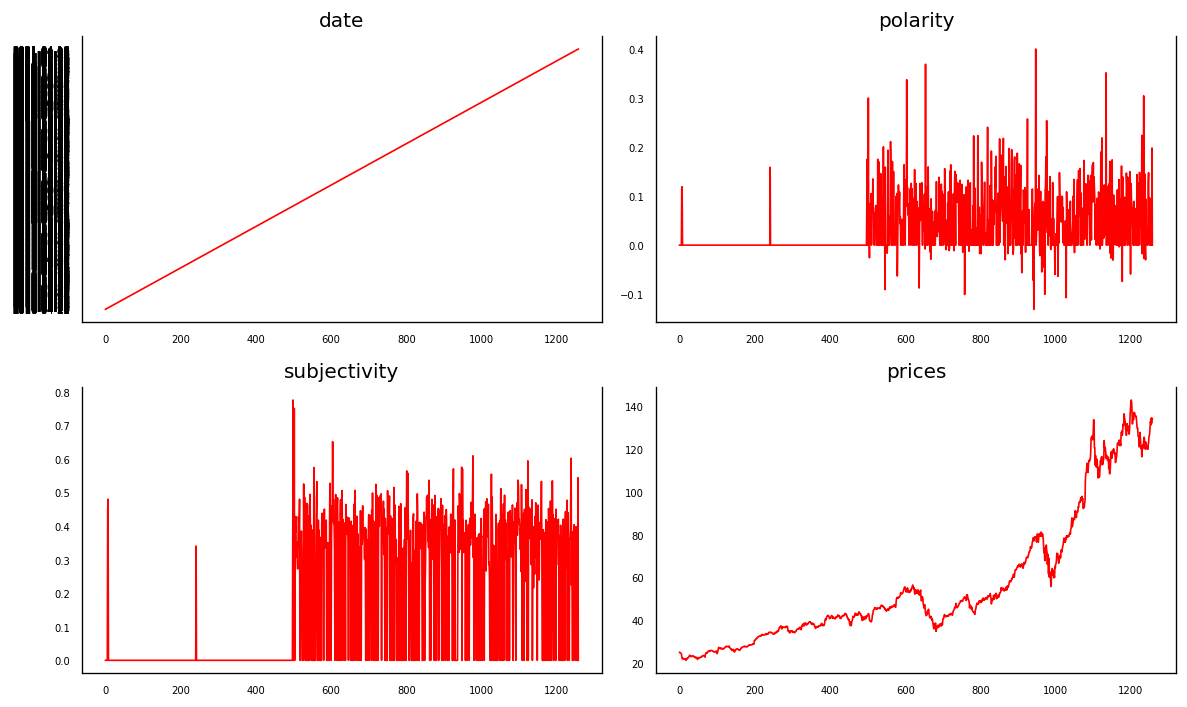

In [10]:
# Vector Auto Regression VAR
# example: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ 

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = data_set[data_set.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(data_set.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

# split the data
nobs = int(data_set.shape[0] * 0.2)
df_train, df_test = data_set[0:-nobs], data_set[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

# NOTE: needs to be completed 

In [ ]:
## LSTM model ##
# example: https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/ 
# another example: https://analyticsindiamag.com/how-to-do-multivariate-time-series-forecasting-using-lstm/ 




In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv("../csv_data/AAPL.csv", low_memory=False)


In [6]:
# sort
df.sort_values('date')

# delete missing prices data
df = df[df['prices'].notna()]
# df = df[df['polarity'].notna()]
# df = df[df['subjectivity'].notna()]

# if the values are Nan, convert to 0
df['polarity'] = df['polarity'].fillna(0)
df['subjectivity'] = df['subjectivity'].fillna(0)


# delete unneeded columns: 'title' & 'description'
df.drop(['ticker', 'title', 'description'], axis=1, inplace=True)

#  combine rows with the same date (some days have multiple news, so, compine them and take the average)
df = df.groupby(['date'],as_index=False).agg({'polarity': 'mean', 'subjectivity': 'mean', 'prices': 'mean',})

# get the difference between the price today and the last day
df['diff'] = df['prices'].diff()

# set flags
conditions = [
    (df['diff'] > 0 ),
    (df['diff'] == 0 ),
    (df['diff'] < 0 )
]

values = [1,0,-1]

df['flag'] = np.select(conditions, values)

In [31]:
#df.to_csv('../csv_data/AAPL.csv', index = False, encoding='utf-8')

data_set = pd.read_csv('../csv_data/AAPL.csv', low_memory=False)

# making the decimal points
# data_set.polarity = data_set.polarity.apply(np.ceil)
# data_set.polarity.c(1)
# data_set['polarity'] = np.ceil(data_set.polarity * 10**2) / (10**2)
# data_set.polarity = data_set.polarity.round(1)
# data_set.subjectivity = data_set.subjectivity.round(1)
# data_set = data_set[data_set['polarity'] != 0]
# data_set = data_set[data_set['subjectivity'] != 0]
# data_set.to_csv('../csv_data/AAPL.csv', index = False, encoding='utf-8')
data_set

,date,polarity,subjectivity,prices,diff,flag
6,2016-04-27,0.1,0.4,22.75,-1.51,-1
7,2016-04-28,0.1,0.5,22.05,-0.70,-1
241,2017-04-03,0.2,0.3,34.12,0.01,1
498,2018-04-11,0.1,0.4,41.59,-0.20,-1
499,2018-04-12,0.2,0.8,42.00,0.41,1
...,...,...,...,...,...,...
1240,2021-03-23,0.1,0.4,122.54,-0.85,-1
1246,2021-03-31,0.1,0.4,122.15,2.25,1
1247,2021-04-01,0.1,0.4,123.00,0.85,1
1250,2021-04-07,0.1,0.4,127.90,1.69,1
